<a href="https://colab.research.google.com/github/jacklmg75/data-extraction/blob/main/1_3_Agrupamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agrupamento de Documentos

In [ ]:
%%capture
# coding=UTF-8
import csv

import random
import nltk
from nltk.corpus import stopwords
from nltk.metrics import *

from scipy.sparse import coo_matrix
from sklearn.utils import resample
import numpy as np

from nltk.metrics import scores

import pandas as pd

# tokenizar / quebrar em termos /  bag of words
from nltk.tokenize import word_tokenize
nltk.download('punkt') # faz o download do "tokenizador" que será usado em word_tokenize

# lista de stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords

# Remoção de acentuação
!pip install unidecode
from unidecode import unidecode

# Stopwords
stop_words = stopwords.words('portuguese')

# Stemming
nltk.download('rslp')
from nltk.stem import RSLPStemmer
stemmer = RSLPStemmer()

# Leitura da base de dados

In [ ]:
# Documentos positivos

pos_df = pd.read_csv('https://raw.githubusercontent.com/clarissacastella/eniac2018/master/train_EPTC_POA_v3nbal_1.data',
                     on_bad_lines='skip',
                     header=None,
                     names=["text"])
pos_df.head(2)

,text
0,Av. Borges de Medeiros liberada. Manifestantes seguem concentrados em frente ao Paço Municipal.
1,RT @Trensurb: #TrensurbInforma Bom dia! Trens e aeromóvel estão operando normalmente nesta manhã...


In [ ]:
pos_df["sentimento"]="pos"
pos_df.head(2)

,text,sentimento
0,Av. Borges de Medeiros liberada. Manifestantes seguem concentrados em frente ao Paço Municipal.,pos
1,RT @Trensurb: #TrensurbInforma Bom dia! Trens e aeromóvel estão operando normalmente nesta manhã...,pos


In [ ]:
# Documentos negativos

neg_df = pd.read_csv('https://raw.githubusercontent.com/clarissacastella/eniac2018/master/train_EPTC_POA_v3nbal_0.data',
                     on_bad_lines='skip',
                     header=None,
                     names=["text"])
neg_df["sentimento"]="neg"
neg_df.head(2)

,text,sentimento
0,Trânsito acentuado nos dois sentidos da Av. Carlos Gomes x Campos Sales.,neg
1,Trânsito acentuado na saída da Capital pela Av. da Legalidade e da Democracia.,neg


In [ ]:
# Documentos neutros

neu_df = pd.read_csv('https://raw.githubusercontent.com/clarissacastella/eniac2018/master/train_EPTC_POA_v3nbal_2.data',
                     on_bad_lines='skip',
                     header=None,
                     names=["text"])
neu_df["sentimento"]="neu"
neu_df.head(2)

,text,sentimento
0,Linhas de ônibus especiais são ativadas no feriado de Finados: https://t.co/a4Yze75yWN,neu
1,RT @triunfoconcepa: CONCEPA informa: Não há previsão de içamentos no vão móvel da Ponte do Guaíba,neu


In [ ]:
# Unificando o dataset

dataset = pd.concat([pos_df, neu_df, neg_df], axis=0, ignore_index=True)
dataset.head(2)

,text,sentimento
0,Av. Borges de Medeiros liberada. Manifestantes seguem concentrados em frente ao Paço Municipal.,pos
1,RT @Trensurb: #TrensurbInforma Bom dia! Trens e aeromóvel estão operando normalmente nesta manhã...,pos


In [ ]:
dataset.shape

(3951, 2)

In [ ]:
dataset.drop_duplicates(inplace=True)
dataset.shape

(2852, 2)

In [ ]:
# Dicionário de stopwords suplementar

url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-pt/master/stopwords-pt.txt'
stopwords_from_github = pd.read_csv(url,header=None)
stop_words = stop_words + stopwords_from_github[0].tolist()  # Agregando as novas stopwords à lista padrão
stop_words = set(stop_words + ["http", "https"])  # Agregando as novas termos

# Nossa função de preprocessamento

'''
Recebe um texto bruto (raw text)
Retorna o bag of words com todos os termos normalizados (clean text)
'''
def text_preprocess(text):
  tokens = word_tokenize(text)
  words = [word.lower() for word in tokens]
  words = [word for word in words if word.isalnum()]
  words = [w for w in words if not w in stop_words]
  words = [unidecode(w) for w in words]
  words = [w for w in words if len(w) >1 ]
  return(words)

## Criando os vetores com as frequências de termos

In [ ]:
documents_text = dataset['text']  # recebemos o texto
doc_text = documents_text[0] # Apenas a 1a linha (posição 0)
print(doc_text)
print(text_preprocess(doc_text))

Av. Borges de Medeiros liberada. Manifestantes seguem concentrados em frente ao Paço Municipal.
['av', 'borges', 'medeiros', 'liberada', 'manifestantes', 'seguem', 'concentrados', 'frente', 'paco', 'municipal']


In [ ]:
# TF IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df = dataset.copy()

# criando vetores para TODA a base
tfidf_vectorizer = TfidfVectorizer(tokenizer=text_preprocess)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

# similaridade
similarity = cosine_similarity(tfidf_matrix[0], tfidf_matrix)
df["similarity"] = similarity.ravel()

## Validando a função de similaridade

In [ ]:
pd.options.display.max_colwidth = 100

print("Texto:",df.text[0])
df.sort_values("similarity",ascending=False).head()

Texto: Av. Borges de Medeiros liberada. Manifestantes seguem concentrados em frente ao Paço Municipal.


,text,sentimento,similarity
0,Av. Borges de Medeiros liberada. Manifestantes seguem concentrados em frente ao Paço Municipal.,pos,1.000000
2198,Manifestantes se concentram em frente ao Paço Municipal na Av. Borges de Medeiros. Duas faixas b...,neg,0.642764
1206,Grupo acessou a Av. Borges de Medeiros e se concentra em frente ao Paço Municipal.,neu,0.569807
304,Av. Borges de Medeiros liberada,pos,0.475396
1107,Após parada no Paço Municipal,neu,0.427237


## Agrupamento (Clustering)

De posse dos vetores de termos podemos além de fazer a similaridade individual, fazer agrupamentos com todos documentos similares entre si

In [ ]:
# Criamos um modelo com o objetivo de gerar 10 grupos na coleção de documentos (matriz de termos)

from sklearn.cluster import KMeans # K-médias
import numpy as np

kmeans = KMeans(n_clusters=10, random_state=0).fit(tfidf_matrix)
kmeans.labels_

array([0, 9, 4, ..., 3, 0, 3], dtype=int32)

In [ ]:
# Executa o algorítmo kmeans e recebe a predição de qual grupo pertence cada documento da base

df["grupo"] = kmeans.predict(tfidf_matrix)
df.head(5)

,text,sentimento,similarity,grupo
0,Av. Borges de Medeiros liberada. Manifestantes seguem concentrados em frente ao Paço Municipal.,pos,1.000000,0
1,RT @Trensurb: #TrensurbInforma Bom dia! Trens e aeromóvel estão operando normalmente nesta manhã...,pos,0.000000,9
2,Bom dia! Trânsito fluindo bem nos dois sentidos da Av. Ipiranga,pos,0.027870,4
3,j02 - Trânsito fluindo bem nos dois sentidos do Túnel da Conceição.,pos,0.000000,2
4,Trânsito fluindo bem na saída da Capital pela Av. da Legalidade e da Democracia.,pos,0.022754,6


## Análise dos Grupos

In [ ]:
# Função para plotar a contagem de documentos em cada grupo
# e a nuvem de termos em cada um

from wordcloud import WordCloud
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt

def plot_groups_info(docs):

  # frequencia dos sentimentos no grupo
  sns.countplot(data=docs, x='sentimento',
                palette=dict(pos="green", neu="orange", neg="red",
                aspect=7))

  # nuvem de palavras
  tokens = [text_preprocess(doc) for doc in docs.text]
  wordcloud_conf = WordCloud(width=500,
                        max_font_size=80,#, max_words=100,
                        background_color="white")

  tagcloud = wordcloud_conf.generate(' '.join([' '.join(words) for words  in tokens]))

  plt.figure(figsize=(14,5))
  plt.imshow(tagcloud, interpolation="bilinear")
  plt.axis("on")
  plt.show()

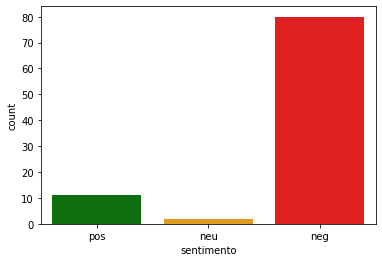

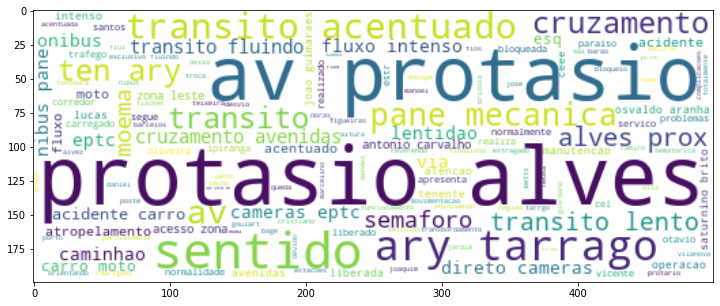

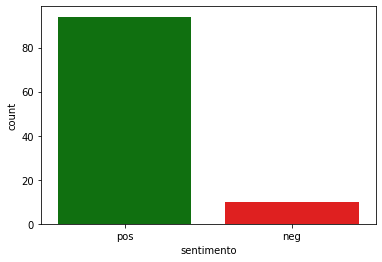

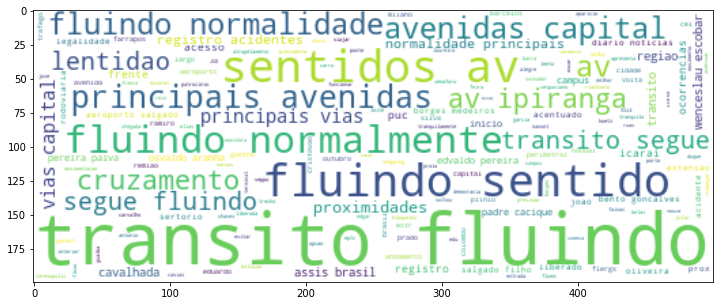

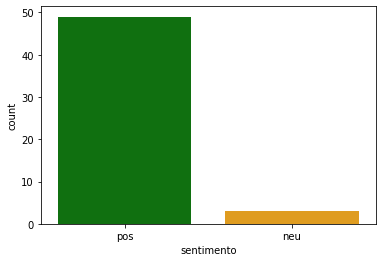

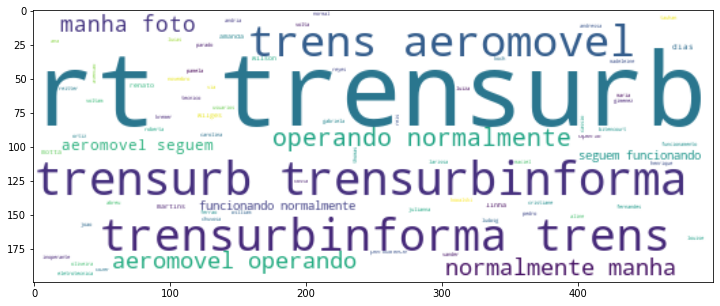

In [ ]:
plot_groups_info(df[df.grupo==1])
plot_groups_info(df[df.grupo==4])
plot_groups_info(df[df.grupo==9])